## LoRaWAN Regression to predict Distances

In [164]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
import haversine as hs
from haversine import Unit

In [165]:
def regression_results(y_test, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_test, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_test, y_pred) 
    mse=metrics.mean_squared_error(y_test, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_test, y_pred)
    r2=metrics.r2_score(y_test, y_pred)

    print('   explained_variance: ', round(explained_variance,4))    
    print('   r2: ', round(r2,4))
    print('   MAE: ', round(mean_absolute_error,4))
    print('   MSE: ', round(mse,4))
    print('   RMSE: ', round(np.sqrt(mse),4))

### Data Preperation

In [186]:
label = LabelEncoder()
data = pd.read_pickle("../../helium-api-wrapper/data/challenges_with_location.pkl")
data["datarate"] = label.fit_transform(data["datarate"])
# data["valid"] = label.fit_transform(data["valid"])
# NUM_WITTNESSES = int(data.index[-1]/data["key"].values[-1])

for i in range(len(data)):
    data["distance"][i] = hs.haversine(
        (data["challengee_lat"].iloc[i], data["challengee_lng"].iloc[i]),
        (data["witness_lat"].iloc[i], data["witness_lng"].iloc[i]),
        unit=Unit.METERS
    )
    
data["distance"]
data.drop(["challengee", "witness", "hash"], axis=1, inplace=True)

data

C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_19956\4103190872.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["distance"][i] = hs.haversine(


,challengee_lat,challengee_lng,witness_lat,witness_lng,signal,snr,datarate,time,distance
0,33.987525,-117.760349,33.975588,-117.725527,-129,-12.8,1,1668371552,3474.261956
1,33.987525,-117.760349,33.999364,-117.747191,-118,-5.2,1,1668371552,1790.145012
2,33.987525,-117.760349,33.979297,-117.747761,-117,-1.8,1,1668371552,1477.845156
3,33.987525,-117.760349,33.988356,-117.751785,-107,5.5,1,1668371552,794.931456
4,33.987525,-117.760349,33.989016,-117.759165,-105,8.5,1,1668371552,198.548052
...,...,...,...,...,...,...,...,...,...
10294,0.000000,0.000000,0.000000,0.000000,-105,1.8,1,1668371369,0.000000
10295,0.000000,0.000000,0.000000,0.000000,-119,-8.2,1,1668371369,0.000000
10296,0.000000,0.000000,0.000000,0.000000,-118,-7.0,1,1668371369,0.000000
10297,0.000000,0.000000,0.000000,0.000000,-112,-6.5,1,1668371369,0.000000


In [190]:
data = data.drop(data[(data["snr"].values < 3) & (data["snr"].values > -7.5)].index)
data = data.drop(data[data["signal"].values < -100].index)
data = data.drop(data[data["distance"].values == 0].index)
data = data.drop(data[data["distance"].values > 15000].index)
data

,challengee_lat,challengee_lng,witness_lat,witness_lng,signal,snr,datarate,time,distance
5,33.987525,-117.760349,33.986242,-117.757921,-62,9.8,1,1668371552,265.371504
11,30.318300,-90.991508,30.320558,-90.997692,-93,9.2,1,1668371552,644.447594
23,40.636649,22.940386,40.647572,22.951109,-89,4.2,0,1668371552,1514.578198
25,40.636649,22.940386,40.641975,22.925846,-83,3.8,0,1668371552,1362.309092
53,31.663485,-106.372491,31.635912,-106.381788,-86,8.5,1,1668371552,3189.765706
...,...,...,...,...,...,...,...,...,...
682,40.252715,-83.041185,40.251931,-83.046011,-45,11.2,1,1668371552,418.755697
683,40.252715,-83.041185,40.255802,-83.030011,-31,13.0,1,1668371552,1008.387911
696,56.662964,16.323998,56.665919,16.317417,-95,6.8,0,1668371552,519.365730
709,41.064801,-7.794917,41.059916,-7.792243,-98,3.6,0,1668371552,587.611076


In [191]:
data.describe()

,challengee_lat,challengee_lng,witness_lat,witness_lng,signal,snr,datarate,time,distance
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,7.400000e+01,74.000000
mean,43.786298,-41.780640,43.783050,-41.785036,-84.189189,7.641216,0.500000,1.668372e+09,2225.964120
std,7.306899,58.075492,7.309299,58.075135,16.815417,5.269279,0.503413,0.000000e+00,2880.926101
min,30.307940,-122.795593,30.307203,-122.801538,-100.000000,-20.000000,0.000000,1.668372e+09,17.860550
25%,40.252715,-94.800230,40.250323,-94.805068,-96.750000,6.050000,0.000000,1.668372e+09,463.733989
50%,43.719113,-40.723581,43.735544,-40.739900,-89.000000,8.350000,0.500000,1.668372e+09,1059.352796
75%,49.213136,18.284835,49.219422,18.243025,-79.000000,10.950000,1.000000,1.668372e+09,2507.647220
max,59.413057,41.132225,59.441270,41.136897,-23.000000,13.200000,1.000000,1.668372e+09,12200.536907


In [192]:
y = data["distance"]
X = data.drop(["distance", "challengee_lat", "challengee_lng"], axis=1)
X

,witness_lat,witness_lng,signal,snr,datarate,time
5,33.986242,-117.757921,-62,9.8,1,1668371552
11,30.320558,-90.997692,-93,9.2,1,1668371552
23,40.647572,22.951109,-89,4.2,0,1668371552
25,40.641975,22.925846,-83,3.8,0,1668371552
53,31.635912,-106.381788,-86,8.5,1,1668371552
...,...,...,...,...,...,...
682,40.251931,-83.046011,-45,11.2,1,1668371552
683,40.255802,-83.030011,-31,13.0,1,1668371552
696,56.665919,16.317417,-95,6.8,0,1668371552
709,41.059916,-7.792243,-98,3.6,0,1668371552


In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1007486)

### Linear Regression Model

In [198]:
lin = LinearRegression()
lin.fit(X_train, y_train)
yPred = lin.predict(X_test)
regression_results(y_test, yPred)

   explained_variance:  0.4333
   r2:  0.4332
   MAE:  2049.2371
   MSE:  7058869.9756
   RMSE:  2656.8534


In [219]:
poly_transformer = PolynomialFeatures(degree=2)
X_poly_train = poly_transformer.fit_transform(X_train)
X_poly_test = poly_transformer.fit_transform(X_test)
linear_regressor = LinearRegression()
linear_regressor.fit(X_poly_train, y_train)
yPred = linear_regressor.predict(X_poly_test)
regression_results(y_test, yPred)

   explained_variance:  -2.3031
   r2:  -2.3055
   MAE:  4528.4201
   MSE:  41168127.3083
   RMSE:  6416.2393


In [234]:
funktion_transformer = FunctionTransformer(np.log1p, validate=True)

X_log_train = X_train.copy()
X_log_train["signal"] = X_log_train["signal"]*-1
X_log_train["snr"] = X_log_train["snr"]**2
X_log_train.drop(["witness_lat",	"witness_lng"], axis=1, inplace=True)

X_log_test = X_test.copy()
X_log_test["signal"] = X_log_test["signal"]*-1
X_log_test["snr"] = X_log_test["snr"]**2
X_log_test.drop(["witness_lat",	"witness_lng"], axis=1, inplace=True)

X_log_train = funktion_transformer.transform(X_log_train)
X_log_test = funktion_transformer.transform(X_log_test)

linear_regressor = LinearRegression()
linear_regressor.fit(X_log_train, y_train)
yPred = linear_regressor.predict(X_log_test)
regression_results(y_test, yPred)

   explained_variance:  -0.0175
   r2:  -0.0403
   MAE:  2720.7678
   MSE:  12955718.7394
   RMSE:  3599.4053


f:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
f:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


### Random Forest Regression

In [176]:
random_forest_regression = RandomForestRegressor(n_estimators=100, max_depth=20)
random_forest_regression.fit(X_train, y_train)
random_forest_regression_yPred = random_forest_regression.predict(X_test)

regression_results(y_test, random_forest_regression_yPred)

   explained_variance:  0.4383
   r2:  -0.0888
   MAE:  3831.9622
   MSE:  30328449.169
   RMSE:  5507.1271


### Randomized Search

In [177]:
rf  = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("estimator", RandomForestRegressor(warm_start=True, oob_score=True))
    ]
)

rgrid = {
    "estimator__n_estimators": np.arange(50,500,10),
    "estimator__criterion": ["squared_error", "absolute_error", "poisson"],
    "estimator__min_samples_split":np.arange(1, 50),
    "estimator__min_samples_leaf":np.arange(1, 50),
    "estimator__max_features": ["sqrt", "log2"],
    "estimator__max_depth": np.arange(2, 20)
}


opt_rf = RandomizedSearchCV(rf, rgrid, cv = 5, scoring="neg_root_mean_squared_error", random_state=1007486)
opt_rf.fit(X_train, y_train)
yrf_pred = opt_rf.predict(X_test)
regression_results(y_test, yrf_pred)
print(opt_rf.best_params_)

   explained_variance:  0.1813
   r2:  0.0329
   MAE:  4526.0536
   MSE:  26936643.5304
   RMSE:  5190.0524
{'estimator__n_estimators': 150, 'estimator__min_samples_split': 34, 'estimator__min_samples_leaf': 7, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 4, 'estimator__criterion': 'squared_error'}


### Gridsearch

In [119]:
rf  = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("estimator", RandomForestRegressor(warm_start=True, oob_score=True))
    ]
)

rgrid = {
    "estimator__n_estimators": np.arange(50,200,10),
    "estimator__max_depth": np.arange(2, 20)
}


opt_rf = GridSearchCV(rf, rgrid, cv = 5, scoring="neg_root_mean_squared_error")
opt_rf.fit(X_train, y_train)
yrf_pred = opt_rf.predict(X_test)
regression_results(y_test, yrf_pred)
print(opt_rf.best_params_)

   explained_variance:  0.7905
   r2:  -0.2318
   MAE:  730.0524
   MSE:  642171.7465
   RMSE:  801.3562
{'estimator__max_depth': 11, 'estimator__n_estimators': 80}


### GradientBoostingRegressor

In [195]:

pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("estimator", GradientBoostingRegressor())
    ]
)

grid = {
    "estimator__n_estimators": np.arange(10,500,10),
    "estimator__learning_rate": np.linspace(1e-3, 0.5,50),
    "estimator__max_depth": np.arange(1,15), 
    "estimator__min_samples_split": np.linspace(1e-7, 0.99,100),
    "estimator__max_features": ["sqrt", "log2"],
    "estimator__loss": ["squared_error", "absolute_error", "huber", "quantile"]
}

gbt_grid = RandomizedSearchCV(pipeline, grid, cv=5,scoring="neg_root_mean_squared_error", random_state=1007486)

gbt_grid.fit(X_train, y_train)
y_pred = gbt_grid.predict(X_test)
regression_results(y_test, y_pred)
print(gbt_grid.best_params_)

   explained_variance:  0.4254
   r2:  0.414
   MAE:  2248.7163
   MSE:  7298728.36
   RMSE:  2701.6159
{'estimator__n_estimators': 430, 'estimator__min_samples_split': 0.3100000686868687, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 5, 'estimator__loss': 'absolute_error', 'estimator__learning_rate': 0.08246938775510204}


### Neural Network

In [141]:
pipe_MLPRegressor = Pipeline(
    [
        ('scaler',  StandardScaler()),
        ('MLPRegressor', MLPRegressor(random_state = 42, max_iter=1000))
    ]
)

grid_params_MLPRegressor = [{
    'MLPRegressor__solver': ['lbfgs'],
    'MLPRegressor__activation' : ['relu','logistic','tanh'],
    'MLPRegressor__hidden_layer_sizes':[(2,), (4,),(2,2),(4,4),(4,2),(10,10),(2,
2,2)],}]


CV_mlpregressor = GridSearchCV(estimator = pipe_MLPRegressor, param_grid = grid_params_MLPRegressor, cv = 5, return_train_score=True, verbose=0)

CV_mlpregressor.fit(X_train, y_train)
y_pred = gbt_grid.predict(X_test)
regression_results(y_test, y_pred)
print(CV_mlpregressor.best_params_)

f:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
f:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


   explained_variance:  0.9194
   r2:  -0.9538
   MAE:  988.1907
   MSE:  1018526.7438
   RMSE:  1009.2209
{'MLPRegressor__activation': 'tanh', 'MLPRegressor__hidden_layer_sizes': (2, 2), 'MLPRegressor__solver': 'lbfgs'}


### PCA

In [123]:
rf  = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("decomposer", PCA()),
        ("estimator", RandomForestRegressor(warm_start=True, oob_score=True))
    ]
)

rgrid = {
    "estimator__n_estimators": np.arange(50,500,10),
    "estimator__criterion": ["squared_error", "absolute_error", "poisson"],
    "estimator__min_samples_split":np.arange(1, 50),
    "estimator__min_samples_leaf":np.arange(1, 50),
    "estimator__max_features": ["sqrt", "log2"],
    "estimator__max_depth": np.arange(2, 20), 
    "decomposer__n_components": np.arange(1, 6)
}


opt_rf = RandomizedSearchCV(rf, rgrid, cv = 5, scoring="neg_root_mean_squared_error", random_state=1007486)
opt_rf.fit(X_train, y_train)
yrf_pred = opt_rf.predict(X_test)
regression_results(y_test, yrf_pred)
print(opt_rf.best_params_)

f:\Python\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "f:\Python\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "f:\Python\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "f:\Python\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "f:\Python\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_

   explained_variance:  0.0
   r2:  -0.0575
   MAE:  722.0216
   MSE:  551268.5876
   RMSE:  742.4746
{'estimator__n_estimators': 260, 'estimator__min_samples_split': 17, 'estimator__min_samples_leaf': 30, 'estimator__max_features': 'log2', 'estimator__max_depth': 3, 'estimator__criterion': 'absolute_error', 'decomposer__n_components': 3}


In [126]:
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("decomposer", PCA()),
        ("estimator", GradientBoostingRegressor())
    ]
)

grid = {
    "estimator__n_estimators": np.arange(10,500,10),
    "estimator__learning_rate": np.linspace(1e-3, 0.5,50),
    "estimator__max_depth": np.arange(1,15), 
    "estimator__min_samples_split": np.linspace(1e-7, 0.99,100),
    "estimator__max_features": ["sqrt", "log2"],
    "estimator__loss": ["squared_error", "absolute_error", "huber", "quantile"],
    "decomposer__n_components": np.arange(1, 7)
}

gbt_grid = RandomizedSearchCV(pipeline, grid, cv=5,scoring="neg_root_mean_squared_error", random_state=1007486)

gbt_grid.fit(X_train, y_train)
y_pred = gbt_grid.predict(X_test)
regression_results(y_test, y_pred)
print(gbt_grid.best_params_)

   explained_variance:  0.0213
   r2:  -0.3765
   MAE:  714.2855
   MSE:  717615.2919
   RMSE:  847.1218
{'estimator__n_estimators': 120, 'estimator__min_samples_split': 0.24000007575757576, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 7, 'estimator__loss': 'huber', 'estimator__learning_rate': 0.001, 'decomposer__n_components': 3}


### Visualization

f:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
f:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


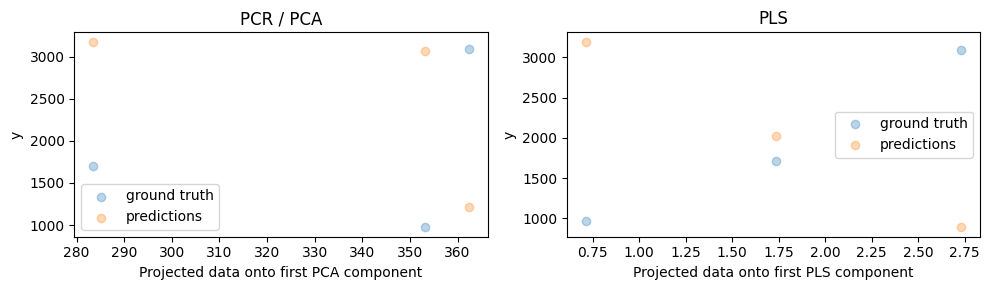

In [61]:

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

### Trilateration Test

https://www.alanzucconi.com/2017/03/13/positioning-and-trilateration/

In [ ]:
def mse(x, locations, distances):
    mse = 0.0
    for location, distance in zip(locations, distances):
        distance_calculated = hs.haversine(tuple(x), tuple(location), Unit.METERS)
        mse += math.pow(distance_calculated - distance, 2.0)
    return mse / len(distances)

In [ ]:

min_dist_row = df.loc[:2].sort_values("distance [m]").iloc[0]
initial_location = min_dist_row["lat"], min_dist_row["lng"]

points = [ p for p in list(zip(df["lat"], df["lng"], df["distance [m]"]))]

locations = [(p[0], p[1]) for p in points]
# distances = [p[2] + random.random()*40-20 for p in points[:3]] # experiment with noise
distances = [p[2] for p in points[:3]]

result = minimize(
    mse,                         # The error function
    initial_location,            # The initial guess (e.g. location with minimum distance to point)
    args=(locations, distances), # Additional parameters for mse
    method='L-BFGS-B',           # The optimisation algorithm
    options={
        'ftol':1e-5,         # Tolerance
        'maxiter': 1e+7      # Maximum iterations
    })
location = result.x
location

array([47.58403 , 12.172852])